## Imports

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

from model_toolbox import gbm

%matplotlib inline

In [2]:
DATA_LOC = '../../data'

## Load data 

In [ ]:
!gsutil cp gs://cytora-user-jack/bedrock/train_claims.pkl $DATA_LOC
!gsutil cp gs://cytora-user-jack/bedrock/train_policies.pkl $DATA_LOC
!gsutil cp gs://cytora-user-jack/bedrock/test_policies.pkl $DATA_LOC

In [3]:
claims_train = pd.read_pickle(os.path.join(DATA_LOC, 'train_claims.pkl'))
policies_train = pd.read_pickle(os.path.join(DATA_LOC, 'train_policies.pkl'))
policies_test = pd.read_pickle(os.path.join(DATA_LOC, 'test_policies.pkl'))

## Explore data

In [4]:
policies_train.head()

,pol_id,insured,trade,year_built,height,sprinklers,sum_insured
0,1,Company_1,Office,year:1994,4,No,440000.0
1,2,Company_2,Retail,year:1994,2,Yes,440000.0
2,3,Company_3,Office,year:1996,1,No,760000.0
3,4,Company_4,Office,year:1990,2,Yes,760000.0
4,5,Company_5,Retail,year:1991,3,Yes,360000.0


In [5]:
policies_test.head()

,pol_id,insured,trade,year_built,height,sprinklers,sum_insured
0,1,Company_1,Office,year:1991,4,No,10000000.0
1,2,Company_2,Factory,year:1993,5,No,10000000.0
2,3,Company_3,Office,year:1995,2,Yes,1180000.0
3,4,Company_4,Restaurant,year:1995,2,Yes,5100000.0
4,5,Company_5,Office,year:1992,2,Yes,8040000.0


In [6]:
claims_train.head()

,pol_id,claim_id,claim_amount
0,9,1,72862.149801
1,16,2,280000.000000
2,16,3,88734.203456
3,20,4,920000.000000
4,23,5,300097.278576


In [7]:
claims_train['pol_id'].value_counts().value_counts()

1    219909
2     51269
3      9077
4      1373
5       159
6        14
Name: pol_id, dtype: int64

In [8]:
policies_train['sprinklers'].value_counts()

Yes    500056
No     499944
Name: sprinklers, dtype: int64

In [9]:
policies_train['sprinklers'] = ((policies_train['sprinklers'] == 'Yes')*1)
policies_test['sprinklers'] = ((policies_test['sprinklers'] == 'Yes')*1)

policies_train['year_ord'] = pd.to_numeric(policies_train['year_built'].str[-4:]) - 1990
policies_test['year_ord'] = pd.to_numeric(policies_test['year_built'].str[-4:]) - 1990

In [40]:
policies_train['sum_insured'].value_counts()

600000.0     100212
280000.0     100132
440000.0     100124
920000.0     100096
760000.0     100002
840000.0      99913
680000.0      99907
520000.0      99706
360000.0      99659
200000.0      50186
1000000.0     50063
Name: sum_insured, dtype: int64

In [41]:
policies_test['sum_insured'].value_counts()

2160000.0     100295
9020000.0     100255
7060000.0     100197
1180000.0     100035
3140000.0     100023
5100000.0      99869
8040000.0      99848
4120000.0      99669
6080000.0      99620
10000000.0     50420
200000.0       49769
Name: sum_insured, dtype: int64

In [10]:
policies_train['trade'].value_counts()

Retail        250522
Restaurant    250462
Office        249873
Factory       249143
Name: trade, dtype: int64

In [11]:
policies_train['height'].value_counts()

4    200907
2    200167
3    199822
5    199617
1    199487
Name: height, dtype: int64

In [12]:
policies_train['year_built'].value_counts()

year:1991    91402
year:2000    91259
year:1998    91157
year:1993    91111
year:1994    90889
year:1990    90792
year:1999    90760
year:1995    90723
year:1992    90696
year:1996    90658
year:1997    90553
Name: year_built, dtype: int64

In [13]:
combined = policies_train.merge(claims_train, on='pol_id', how='left')

In [14]:
combined.head(10)

,pol_id,insured,trade,year_built,height,sprinklers,sum_insured,year_ord,claim_id,claim_amount
0,1,Company_1,Office,year:1994,4,0,440000.0,4,NaN,NaN
1,2,Company_2,Retail,year:1994,2,1,440000.0,4,NaN,NaN
2,3,Company_3,Office,year:1996,1,0,760000.0,6,NaN,NaN
3,4,Company_4,Office,year:1990,2,1,760000.0,0,NaN,NaN
4,5,Company_5,Retail,year:1991,3,1,360000.0,1,NaN,NaN
5,6,Company_6,Factory,year:1992,2,0,760000.0,2,NaN,NaN
6,7,Company_7,Retail,year:1991,1,0,200000.0,1,NaN,NaN
7,8,Company_8,Office,year:1993,5,1,520000.0,3,NaN,NaN
8,9,Company_9,Factory,year:2000,2,1,760000.0,10,1.0,72862.149801
9,10,Company_10,Retail,year:1991,3,1,920000.0,1,NaN,NaN


In [15]:
combined['severity'] = combined['claim_amount'] / combined['sum_insured']

In [16]:
combined['severity'].describe()

count    356049.000000
mean          0.403283
std           0.362403
min           0.000166
25%           0.090024
50%           0.259732
75%           0.721448
max           1.000000
Name: severity, dtype: float64

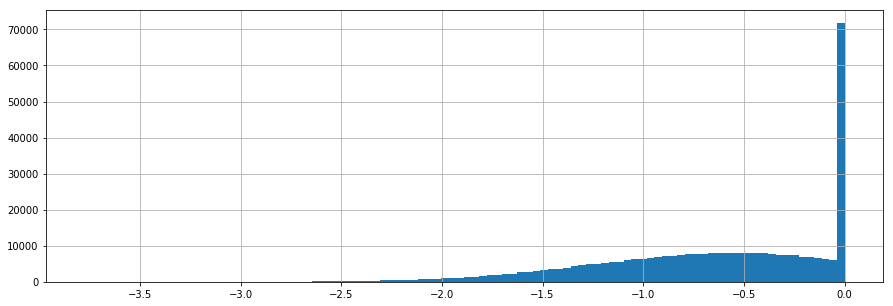

In [17]:
np.log10(combined['severity']).hist(figsize=(15,5), bins=100)

In [18]:
combined.groupby('sum_insured')['severity'].describe()

,count,mean,std,min,25%,50%,75%,max
sum_insured,,,,,,,,
200000.0,18093.0,0.403917,0.361881,0.000489,0.088964,0.262962,0.721448,1.0
280000.0,35564.0,0.403449,0.361768,0.000669,0.090562,0.260186,0.717068,1.0
360000.0,35822.0,0.403666,0.363263,0.000598,0.090602,0.258192,0.725230,1.0
440000.0,35651.0,0.404223,0.361821,0.000521,0.091101,0.261402,0.718016,1.0
520000.0,35150.0,0.403972,0.364292,0.000210,0.089014,0.255829,0.733354,1.0
600000.0,36033.0,0.400323,0.361359,0.000596,0.089114,0.257996,0.713667,1.0
680000.0,35274.0,0.401630,0.361224,0.000409,0.089525,0.260535,0.713584,1.0
760000.0,35633.0,0.403383,0.362798,0.000166,0.090110,0.258883,0.724176,1.0
840000.0,35198.0,0.402905,0.361981,0.000208,0.090587,0.259841,0.716855,1.0


In [19]:
combined.groupby('trade')['severity'].describe()

,count,mean,std,min,25%,50%,75%,max
trade,,,,,,,,
Factory,163132.0,0.504688,0.367525,0.000678,0.161103,0.410190,1.000000,1.0
Office,14044.0,0.271433,0.320275,0.000460,0.040403,0.121733,0.382536,1.0
Restaurant,114893.0,0.332691,0.338173,0.000409,0.065886,0.185158,0.513937,1.0
Retail,63980.0,0.300439,0.330220,0.000166,0.051957,0.150865,0.439669,1.0


In [20]:
combined.groupby('trade')['claim_id'].agg(lambda x: x.notnull().sum())

trade
Factory       163132.0
Office         14044.0
Restaurant    114893.0
Retail         63980.0
Name: claim_id, dtype: float64

## Prep data for frequency modelling

In [21]:
claims_count = claims_train.groupby('pol_id')['claim_id'].size().reset_index().rename(
    columns={'claim_id': 'claim_count'}
)

In [22]:
claims_count.head()

,pol_id,claim_count
0,9,1
1,16,2
2,20,1
3,23,1
4,28,1


In [23]:
policies_train_claim_counts = policies_train.merge(claims_count, on='pol_id', how='left')

In [24]:
policies_train_claim_counts['claim_count'].fillna(0, inplace=True)

In [39]:
policies_train_claim_counts.groupby(['trade', 'sum_insured'])['claim_count'].mean()

trade       sum_insured
Factory     200000.0       0.650380
            280000.0       0.657320
            360000.0       0.662138
            440000.0       0.654048
            520000.0       0.655774
            600000.0       0.660191
            680000.0       0.647231
            760000.0       0.656984
            840000.0       0.648975
            920000.0       0.653214
            1000000.0      0.653641
Office      200000.0       0.060261
            280000.0       0.057610
            360000.0       0.056657
            440000.0       0.056080
            520000.0       0.056363
            600000.0       0.054529
            680000.0       0.055929
            760000.0       0.056400
            840000.0       0.055199
            920000.0       0.055355
            1000000.0      0.055596
Restaurant  200000.0       0.464618
            280000.0       0.458072
            360000.0       0.463337
            440000.0       0.461105
            520000.0       0.449732
    

In [25]:
policies_train_claim_counts['year_ord'] = pd.to_numeric(policies_train_claim_counts['year_built'].str[-4:]) - 1990
policies_test['year_ord'] = pd.to_numeric(policies_test['year_built'].str[-4:]) - 1990

In [26]:
policies_train_claim_counts.head(16)

,pol_id,insured,trade,year_built,height,sprinklers,sum_insured,year_ord,claim_count
0,1,Company_1,Office,year:1994,4,0,440000.0,4,0.0
1,2,Company_2,Retail,year:1994,2,1,440000.0,4,0.0
2,3,Company_3,Office,year:1996,1,0,760000.0,6,0.0
3,4,Company_4,Office,year:1990,2,1,760000.0,0,0.0
4,5,Company_5,Retail,year:1991,3,1,360000.0,1,0.0
5,6,Company_6,Factory,year:1992,2,0,760000.0,2,0.0
6,7,Company_7,Retail,year:1991,1,0,200000.0,1,0.0
7,8,Company_8,Office,year:1993,5,1,520000.0,3,0.0
8,9,Company_9,Factory,year:2000,2,1,760000.0,10,1.0
9,10,Company_10,Retail,year:1991,3,1,920000.0,1,0.0


In [27]:
policies_train_claim_counts.groupby('trade')['claim_count'].value_counts()

trade       claim_count
Factory     0.0            129581
            1.0             84508
            2.0             27881
            3.0              5991
            4.0              1033
            5.0               137
            6.0                12
Office      0.0            236217
            1.0             13279
            2.0               366
            3.0                11
Restaurant  0.0            158251
            1.0             72737
            2.0             16621
            3.0              2522
            4.0               309
            5.0                20
            6.0                 2
Retail      0.0            194150
            1.0             49385
            2.0              6401
            3.0               553
            4.0                31
            5.0                 2
Name: claim_count, dtype: int64

## Frequency modelling

### Create design matrix

In [28]:
Y = policies_train_claim_counts['claim_count']

rating_factors = ['trade', 'year_ord', 'height', 'sprinklers']

X = pd.get_dummies(policies_train_claim_counts[rating_factors], drop_first=True)
X = sm.add_constant(X)
X_test = pd.get_dummies(policies_test[rating_factors], drop_first=True)
X_test = sm.add_constant(X_test)

X.head()

,const,year_ord,height,sprinklers,trade_Office,trade_Restaurant,trade_Retail
0,1.0,4,4,0,1,0,0
1,1.0,4,2,1,0,0,1
2,1.0,6,1,0,1,0,0
3,1.0,0,2,1,1,0,0
4,1.0,1,3,1,0,0,1


### Simple linear regression (ordinary least squares)

In [31]:
%%time
ols_model = sm.OLS(Y, X)
ols_fitted = ols_model.fit()
ols_fitted_reg = ols_model.fit_regularized(alpha=0.001)

CPU times: user 24.6 s, sys: 22.4 s, total: 47.1 s
Wall time: 12.5 s


In [32]:
ols_fitted.params

const               0.660360
year_ord           -0.001285
height              0.000097
sprinklers          0.001106
trade_Office       -0.598570
trade_Restaurant   -0.196049
trade_Retail       -0.399401
dtype: float64

In [33]:
ols_fitted_reg.params

const               0.638823
year_ord           -0.000683
height              0.001104
sprinklers          0.000000
trade_Office       -0.578512
trade_Restaurant   -0.175998
trade_Retail       -0.379344
dtype: float64

In [34]:
mse(Y, ols_fitted.predict())

0.3564605794354054

In [35]:
mse(Y, ols_fitted_reg.predict())

0.3565427445812078

### Pure means 

In [79]:
freq_means = policies_train_claim_counts.groupby(
    ['trade', 'year_ord', 'height', 'sprinklers', 'sum_insured']
)['claim_count'].mean().reset_index().rename(columns={'claim_count': 'mean_freq'})

In [80]:
freq_means.head()

,trade,year_ord,height,sprinklers,sum_insured,mean_freq
0,Factory,0,1,0,200000.0,0.655172
1,Factory,0,1,0,280000.0,0.550607
2,Factory,0,1,0,360000.0,0.697248
3,Factory,0,1,0,440000.0,0.591304
4,Factory,0,1,0,520000.0,0.677130


In [81]:
freq_rms = policies_train_claim_counts.groupby(
    ['trade', 'year_ord', 'height', 'sprinklers', 'sum_insured']
)['claim_count'].agg(lambda x: (x**2).mean()**(1/2)).reset_index().rename(columns={'claim_count': 'rms_freq'})

In [82]:
freq_rms.head()

,trade,year_ord,height,sprinklers,sum_insured,rms_freq
0,Factory,0,1,0,200000.0,1.050451
1,Factory,0,1,0,280000.0,0.926445
2,Factory,0,1,0,360000.0,1.117008
3,Factory,0,1,0,440000.0,0.927831
4,Factory,0,1,0,520000.0,1.022176


In [83]:
Y_means = policies_train_claim_counts.merge(freq_means)['mean_freq']

In [84]:
mse(Y, Y_means)

0.45780184989963674

In [85]:
Y_rms = policies_train_claim_counts.merge(freq_rms)['rms_freq']

In [86]:
mse(Y, Y_rms)

0.5927702236011302

### Generalized Linear Model (GLM)

In [58]:
glm_model = sm.GLM(Y, X, family=sm.families.Poisson())

In [59]:
%%time
glm_fitted = glm_model.fit()
glm_fitted_reg = glm_model.fit_regularized(alpha=0.001)

CPU times: user 5min 8s, sys: 5min 16s, total: 10min 24s
Wall time: 2min 52s


In [60]:
glm_fitted.params

const              -0.407845
year_ord           -0.003611
height              0.000274
sprinklers          0.003110
trade_Office       -2.455296
trade_Restaurant   -0.355841
trade_Retail       -0.941551
dtype: float64

In [61]:
glm_fitted_reg.params

const              -0.404647
year_ord           -0.004720
height             -0.002543
sprinklers          0.000000
trade_Office       -2.374202
trade_Restaurant   -0.334871
trade_Retail       -0.913745
dtype: float64

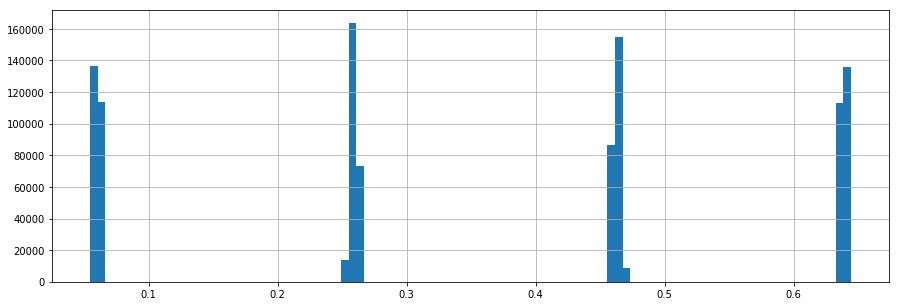

In [62]:
pd.Series(ols_fitted_reg.predict()).hist(figsize=(15,5), bins=100)

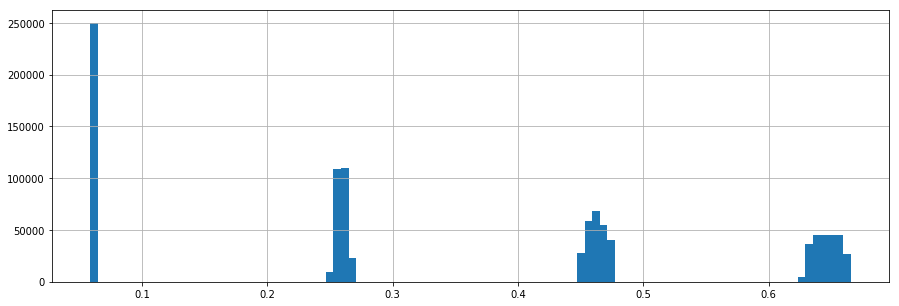

In [63]:
pd.Series(glm_fitted_reg.predict()).hist(figsize=(15,5), bins=100)

In [132]:
mse(Y, glm_fitted.predict())

0.35646570058639315

In [78]:
mse(Y, glm_fitted_reg.predict())

0.3565038399863048

### GBM model (model_toolbox xgboost)

In [133]:
%%time
xgb_model = gbm.LogGBM(objective='count:poisson', silent=0)
xgb_fitted = xgb_model.fit(X, Y)

CPU times: user 1min 2s, sys: 9.99 ms, total: 1min 2s
Wall time: 16.1 s


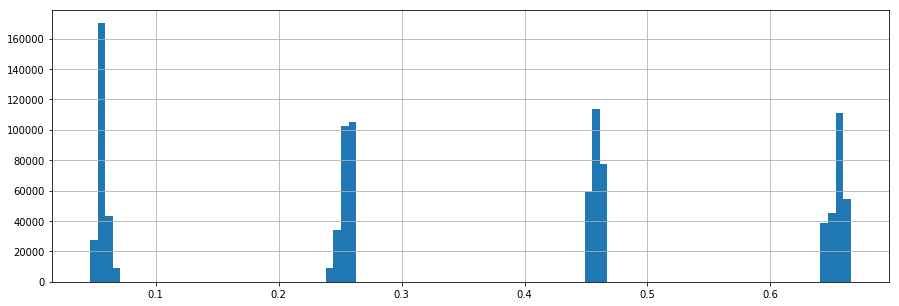

In [134]:
pd.Series(xgb_fitted.predict(X)).hist(figsize=(15,5), bins=100)

In [135]:
mse(Y, xgb_fitted.predict(X))

0.356440827444706

In [136]:
%%time
xgb_model_cv3 = gbm.LogGBM(objective='count:poisson', validation_cv_folds=3, silent=0)
xgb_fitted_cv3 = xgb_model_cv3.fit(X, Y)

CPU times: user 2min 45s, sys: 385 ms, total: 2min 46s
Wall time: 43.3 s


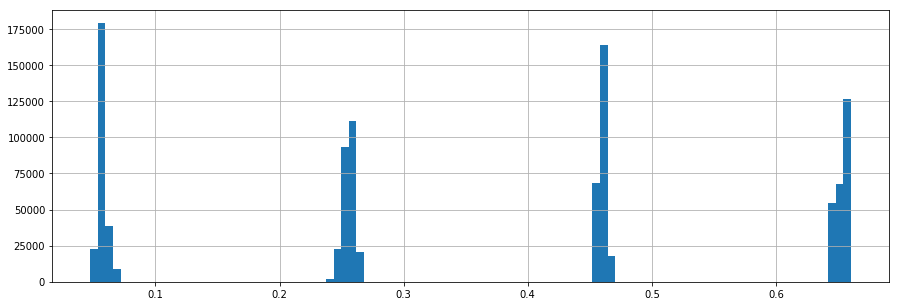

In [137]:
pd.Series(xgb_fitted_cv3.predict(X)).hist(figsize=(15,5), bins=100)

In [138]:
mse(Y, xgb_fitted_cv3.predict(X))

0.35645109112564183

## Severity modelling 

### Data prep

In [87]:
sev_all = combined[combined['severity'] > 0]
sev_partial = sev_all[sev_all['severity'] < 1]

In [88]:
len(sev_all), len(sev_partial)

(356049, 290064)

In [89]:
Y_sev_all = sev_all['severity']
Y_sev_part = sev_partial['severity']

rating_factors = ['trade', 'year_ord', 'height', 'sprinklers']

X_sev_all = pd.get_dummies(sev_all[rating_factors], drop_first=True)
X_sev_all = sm.add_constant(X_sev_all)
X_sev_has_sprinklers = X_sev_all[X_sev_all['sprinklers'] == 1]
X_sev_no_sprinklers = X_sev_all[X_sev_all['sprinklers'] == 0]

X_sev_part = pd.get_dummies(sev_partial[rating_factors], drop_first=True)
X_sev_part = sm.add_constant(X_sev_part)

X_sev_test = pd.get_dummies(policies_test[rating_factors], drop_first=True)
X_sev_test = sm.add_constant(X_sev_test)

### OLS severity model

In [90]:
%%time
ols_sev_all_model = sm.OLS(Y_sev_all, X_sev_all)
ols_sev_all_fitted = ols_sev_all_model.fit()
ols_sev_all_fitted_reg = ols_sev_all_model.fit_regularized(alpha=0.001)

CPU times: user 8.95 s, sys: 8.5 s, total: 17.4 s
Wall time: 4.48 s


In [91]:
ols_sev_all_fitted.params

const               0.613735
year_ord            0.000147
height              0.000003
sprinklers         -0.219158
trade_Office       -0.232828
trade_Restaurant   -0.172288
trade_Retail       -0.203854
dtype: float64

In [92]:
ols_sev_all_fitted_reg.params

const               0.596805
year_ord            0.000571
height              0.001027
sprinklers         -0.213153
trade_Office       -0.198670
trade_Restaurant   -0.160444
trade_Retail       -0.189534
dtype: float64

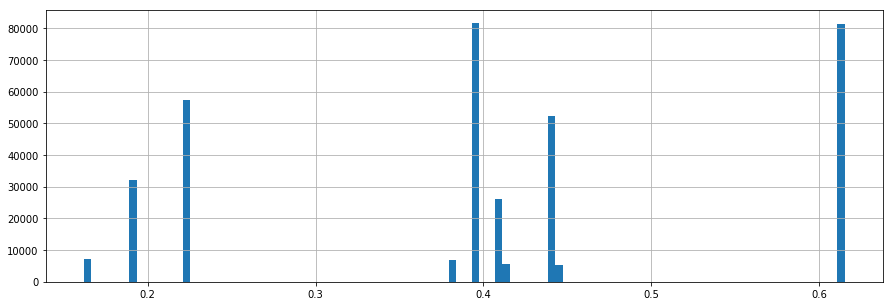

In [93]:
pd.Series(ols_sev_all_fitted.predict()).hist(figsize=(15,5), bins=100)

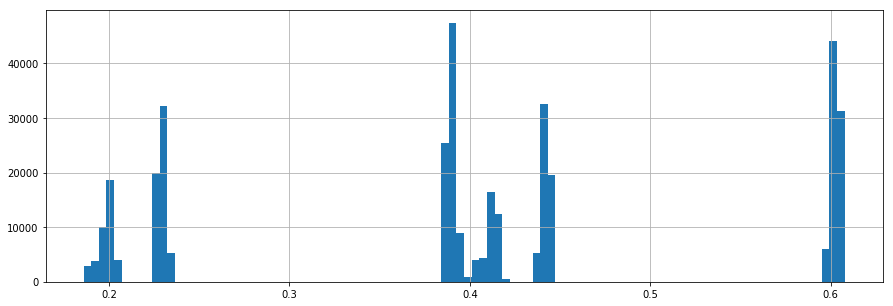

In [94]:
pd.Series(ols_sev_all_fitted_reg.predict()).hist(figsize=(15,5), bins=100)

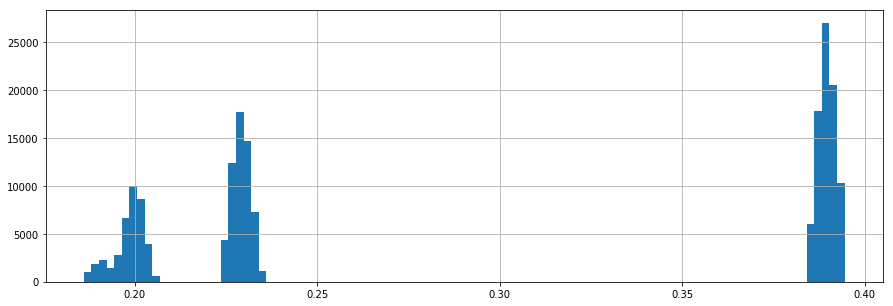

In [95]:
pd.Series(ols_sev_all_fitted_reg.predict(X_sev_has_sprinklers)).hist(figsize=(15,5), bins=100)

In [96]:
mse(Y_sev_all, ols_sev_all_fitted.predict())

0.11042229418569993

In [97]:
mse(Y_sev_all, ols_sev_all_fitted_reg.predict())

0.11050410113229214

In [98]:
ols_sev_part_model = sm.OLS(Y_sev_part, X_sev_part)
ols_sev_part_fitted_reg = ols_sev_part_model.fit_regularized(alpha=0.001)

In [99]:
ols_sev_part_fitted_reg.params

const               0.385122
year_ord            0.000506
height              0.000000
sprinklers         -0.119368
trade_Office       -0.107454
trade_Restaurant   -0.086755
trade_Retail       -0.106873
dtype: float64

In [100]:
mse(Y_sev_part, ols_sev_part_fitted_reg.predict())

0.05490503340401192

In [101]:
trunc_pred = ols_sev_part_fitted_reg.predict(X_sev_all)
mse(Y_sev_all, trunc_pred)

0.13118488291992084

### GLM severity model 

In [102]:
%%time
glm_sev_all_model = sm.GLM(Y_sev_all, X_sev_all, family=sm.families.Gamma(link=sm.families.links.log))
glm_sev_all_fitted = glm_sev_all_model.fit()
glm_sev_all_fitted_reg = glm_sev_all_model.fit_regularized(alpha=0.001) # L1 regularization

CPU times: user 9min 39s, sys: 10min 53s, total: 20min 33s
Wall time: 5min 9s


In [103]:
glm_sev_all_fitted.params

const              -0.354281
year_ord            0.000380
height              0.000017
sprinklers         -0.652269
trade_Office       -0.770305
trade_Restaurant   -0.504735
trade_Retail       -0.637217
dtype: float64

In [116]:
glm_sev_all_fitted.params.abs().sum()

2.919203434318407

In [105]:
glm_sev_all_fitted_reg.params

const              -0.576108
year_ord            0.000806
height              0.006740
sprinklers         -0.516710
trade_Office       -0.592110
trade_Restaurant   -0.361189
trade_Retail       -0.484578
dtype: float64

In [117]:
glm_sev_all_fitted_reg.params.abs().sum()

2.5382409883075825

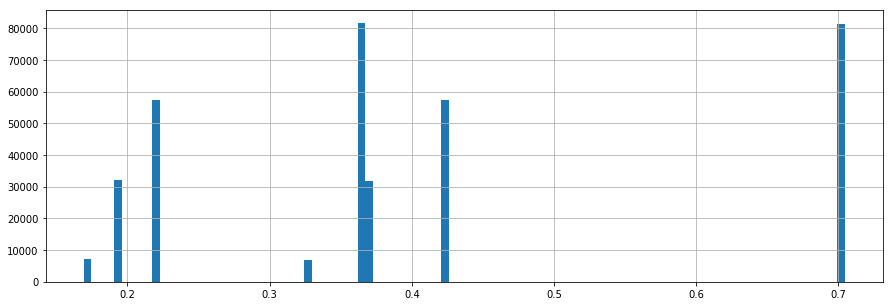

In [107]:
pd.Series(glm_sev_all_fitted.predict()).hist(figsize=(15,5), bins=100)

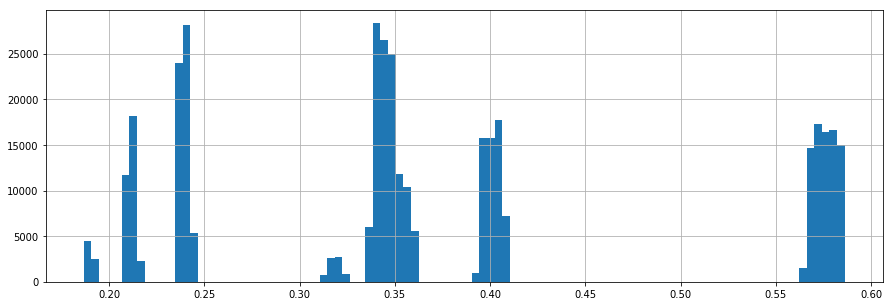

In [108]:
pd.Series(glm_sev_all_fitted_reg.predict()).hist(figsize=(15,5), bins=100)

In [109]:
mse(Y_sev_all, glm_sev_all_fitted.predict())

0.11506981750405229

In [110]:
mse(Y_sev_all, glm_sev_all_fitted_reg.predict())

0.11343749026042604

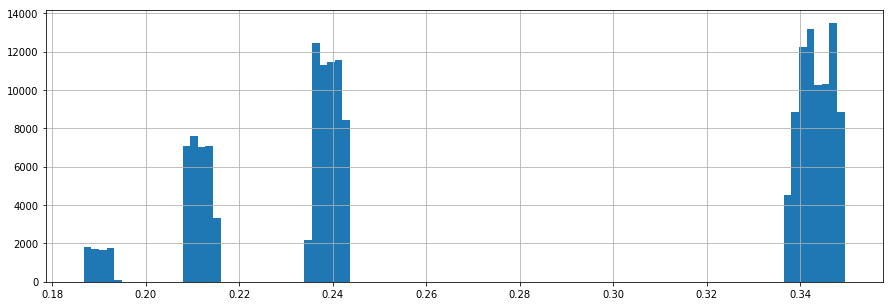

In [111]:
pd.Series(glm_sev_all_fitted_reg.predict(X_sev_has_sprinklers)).hist(figsize=(15,5), bins=100)

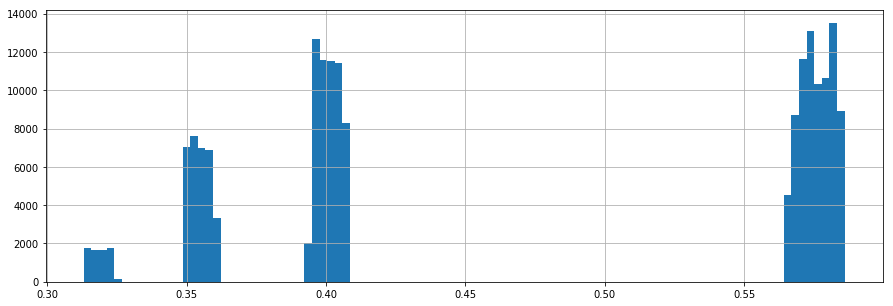

In [112]:
pd.Series(glm_sev_all_fitted_reg.predict(X_sev_no_sprinklers)).hist(figsize=(15,5), bins=100)

In [118]:
%%time
glm_sev_part_model = sm.GLM(Y_sev_part, X_sev_part, family=sm.families.Gamma(link=sm.families.links.log))
glm_sev_part_fitted_reg = glm_sev_part_model.fit_regularized(alpha=0.001)

CPU times: user 8min 9s, sys: 9min 8s, total: 17min 17s
Wall time: 4min 19s


In [119]:
glm_sev_part_fitted_reg.params

const              -0.746329
year_ord            0.000293
height             -0.012561
sprinklers         -0.547240
trade_Office       -0.651790
trade_Restaurant   -0.425089
trade_Retail       -0.548953
dtype: float64

In [120]:
mse(Y_sev_part, glm_sev_part_fitted_reg.predict())

0.05631120950741187

In [121]:
mse(Y_sev_all, glm_sev_part_fitted_reg.predict(X_sev_all))

0.1274332926761977

### GBM model (model_toolbox xgboost)

In [122]:
%%time
xgb_sev_model = gbm.LogGBM(objective='reg:gamma', silent=0)
xgb_sev_fitted = xgb_sev_model.fit(X_sev_all, Y_sev_all)

CPU times: user 19.5 s, sys: 61.7 ms, total: 19.6 s
Wall time: 5.05 s


In [139]:
%%time
xgb_sev_model_cv3 = gbm.LogGBM(objective='reg:gamma', validation_cv_folds=3, silent=0)
xgb_sev_fitted_cv3 = xgb_sev_model_cv3.fit(X_sev_all, Y_sev_all)

CPU times: user 47.7 s, sys: 41.7 ms, total: 47.8 s
Wall time: 12.6 s


In [140]:
mse(Y_sev_all, xgb_sev_fitted.predict(X_sev_all))

0.10931977730568772

In [141]:
mse(Y_sev_all, xgb_sev_fitted_cv3.predict(X_sev_all))

0.10932603876529241

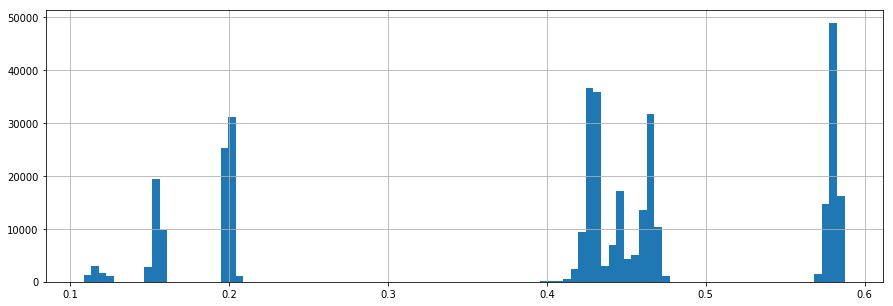

In [142]:
pd.Series(xgb_sev_fitted.predict(X_sev_all)).hist(figsize=(15,5), bins=100)

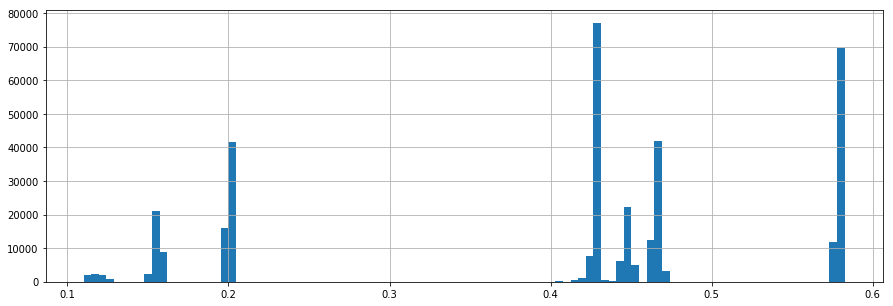

In [143]:
pd.Series(xgb_sev_fitted_cv3.predict(X_sev_all)).hist(figsize=(15,5), bins=100)

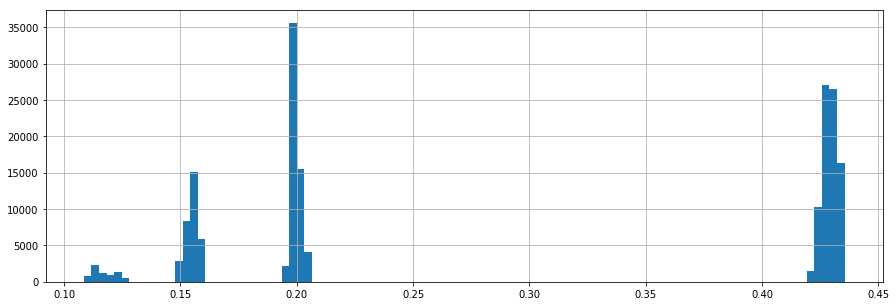

In [144]:
pd.Series(xgb_sev_fitted.predict(X_sev_has_sprinklers)).hist(figsize=(15,5), bins=100)

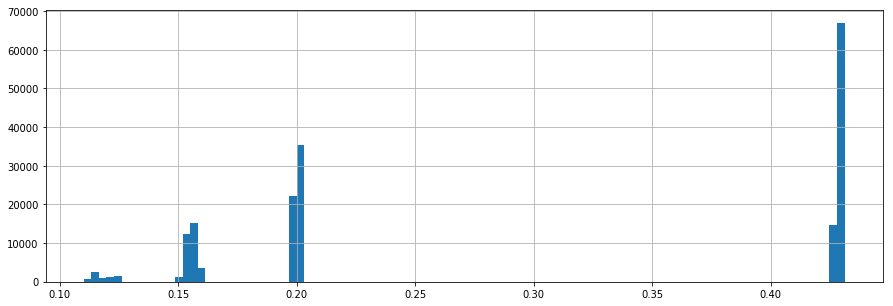

In [145]:
pd.Series(xgb_sev_fitted_cv3.predict(X_sev_has_sprinklers)).hist(figsize=(15,5), bins=100)

## Make predictions 

In [146]:
LM_pred_freq = ols_fitted_reg.predict(X_test)
LM_pred_sev = ols_sev_all_fitted_reg.predict(X_test)

GLM_pred_freq = glm_fitted_reg.predict(X_test)
GLM_pred_sev = glm_sev_all_fitted_reg.predict(X_test)

ML_pred_freq = xgb_fitted_cv3.predict(X_test)
ML_pred_sev = xgb_sev_fitted_cv3.predict(X_test)

In [164]:
policy_ids = policies_test['pol_id']

In [173]:
LM_predictions = pd.concat([policy_ids, LM_pred_freq, LM_pred_sev], axis=1)
LM_predictions.columns = ['pol_id', 'E[N]', 'E[X]']

GLM_predictions = pd.concat([policy_ids, GLM_pred_freq, GLM_pred_sev], axis=1)
GLM_predictions.columns = ['pol_id', 'E[N]', 'E[X]']

ML_predictions = pd.concat([policy_ids, pd.Series(ML_pred_freq), pd.Series(ML_pred_sev)], axis=1)
ML_predictions.columns = ['pol_id', 'E[N]', 'E[X]']

In [171]:
LM_predictions.head()

,pol_id,E[N],E[X]
0,1,0.064043,0.402814
1,2,0.642291,0.603653
2,3,0.059101,0.189890
3,4,0.461615,0.228116
4,5,0.061152,0.188177


In [174]:
GLM_predictions.head()

,pol_id,E[N],E[X]
0,1,0.061192,0.319675
1,2,0.649520,0.582755
2,3,0.060353,0.188734
3,4,0.463845,0.237759
4,5,0.061214,0.188278


In [179]:
ML_predictions.head()

,pol_id,E[N],E[X]
0,1,0.060031,0.417564
1,2,0.659810,0.580783
2,3,0.057421,0.115337
3,4,0.460182,0.200213
4,5,0.060659,0.120828


## Download pickles 

In [181]:
LM_predictions.to_pickle(os.path.join(DATA_LOC, 'jack-LM-01Vanilla.pkl'))
GLM_predictions.to_pickle(os.path.join(DATA_LOC, 'jack-GLM-01Vanilla.pkl'))
ML_predictions.to_pickle(os.path.join(DATA_LOC, 'jack-ML-01Vanilla.pkl'))